This notebook examines how genre list length correlates with gender. It creates visualizations of how gender varies with genre list length and uses a chi-square test to show that the variation is extremely unlikely if there were not a correlation (bias) between genre list length and bias.

For each bin (either an integer or a range of integers), calculate
$$\frac{\text{actual # of male artists in bin}}{\text{expected # of male artists in bin}}$$
where the expected number of male artists in a bin is ${\% \text{male in total sample} \cdot \text{total in bin}}$. 

Other approaches:

The list length counts by gender find that in the 12+ range the expected of male to female is 1. However, there are no female artists with > 11 labels. The statistics don't capture the fact that male artists have features that are not available to female artists. 

The data for lists of length > 6 needs to be dealt with carefully. It is exactly at that point that the statistical significant comes into doubt. First, using 10-fold CV to estimate the ratios there is often a zero value which makes the ratio undefined. Second, when filtering the data to only include, e.g. lengths > 5, then the mean of the error and std of the error indicate that there is not a clear effect.

In [3]:
import importlib.util
spec1 = importlib.util.spec_from_file_location("genre_data_loader", "/Users/Daniel/Code/Genre/src/genre_scripts/genre_data_loader.py")

genre_data_loader = importlib.util.module_from_spec(spec1)
spec1.loader.exec_module(genre_data_loader)
#LoadGenreData = genre_data_loader.LoadGenreData

# import genre_scripts.genre_data_loader as genre_data_loader

import numpy as np
import pandas as pd
from scipy.stats import chisquare, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
seed = 23
%matplotlib inline
import re
from functools import partial
import plotly.graph_objects as go

Import the cleaned data:

In [4]:
%store -r now
now

'2020-07-07-09-58'

In [5]:
# get currrent date for latest version of data set
%store -r now

X_path_train = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now)
y_path_train = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now)
X_path_test = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_test_{}.csv'.format(now)
y_path_test = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_test_{}.csv'.format(now)

In [6]:
# call data loader script
genre_data = genre_data_loader.LoadGenreData(now, X_path_train = X_path_train, y_path_train = y_path_train, 
                                             X_path_test = X_path_test, y_path_test = y_path_test)

In [7]:
# load data with genre sets
data = genre_data.as_sets()
# create list of all genres
list_of_genres = genre_data.get_list_of_genres()

### Import the labels from the whole data set:

In [8]:
genrelist = genre_data.get_list_of_genres()

Get numbers of male and female:

In [9]:
gender_counts = data.gender.value_counts()
mal = gender_counts['male']
fem = gender_counts['female']

Get percentages of male and female:

In [10]:
percent_fem = genre_data.get_percent_female()
percent_mal = genre_data.get_percent_male()

In [11]:
percent_fem, percent_mal

(0.3138332255979315, 0.6861667744020685)

In [12]:
data.shape

(15470, 3)

In [13]:
data.head()

,genrelist_length,gender,genre_set
artist,,,
Pablo_Holman,3,male,"{pop, rock, emo_pop}"
Bobby_Edwards,1,male,{country}
La_Palabra,4,male,"{afro_cuban_jazz, son_montuno, guaracha, salsa..."
Sherrick,2,male,"{r_and_b, soul}"
Allen_Collins,1,male,{southern_rock}


In [14]:
data.shape, data.isnull().sum()

((15470, 3),
 genrelist_length    0
 gender              0
 genre_set           0
 dtype: int64)

In [15]:
tot = data.shape[0]
print('{} total artists'.format(tot))
print('There are {} unique genre labels.'.format(len(genrelist)))
print('{} female artists, or {:0.0f}%'.format(fem, 100*fem/(fem+mal)))
print('{} male artists, or {:0.0f}%'.format(mal, 100*mal/(fem+mal)))

15470 total artists
There are 1491 unique genre labels.
4855 female artists, or 31%
10615 male artists, or 69%


### This function creates a DF with the frequencies of the lengths of lists by gender for a df of the type of "data" above. It is used in the bin_cv_est function below.

In [16]:
def create_length_counts_by_gender(df):
    """
    Input: df = genre data for artists:
        columns: 'genrelist_length','gender'
        index: 'artist'
    
    Output: dataframe with counts by gender and total for each 
        length of genre list in the dataset
    
    Use: called to calculate chi-squared test for bias
    """
    
    df = df.copy(deep = True)
    
    # length counts by gender
    df = df.groupby(['genrelist_length','gender']).count()
    df.columns = ['artist_count']

    df.reset_index(inplace = True)
    df.set_index(['genrelist_length'], inplace = True)
    df.index.name = 'genre list length'
    df = df.pivot(columns = 'gender')
    
    #flatten index and replace with single strings
    df.columns = df.columns.to_flat_index()
    df.columns = [f'{name[1]} '+f'{name[0]}'.replace("_"," ") for name in df.columns]
    df.fillna(value = 0, inplace = True)
    #create total count
    df['total'] = df[df.columns[0]]+df[df.columns[1]]
    df = df.astype('int32')
    
    return df

In [17]:
lcbg = create_length_counts_by_gender(data)

In [18]:
lcbg

,female artist count,male artist count,total
genre list length,,,
1,1306,3149,4455
2,1299,2521,3820
3,1072,2043,3115
4,629,1367,1996
5,305,755,1060
6,155,410,565
7,49,189,238
8,20,99,119
9,10,39,49


In [28]:
def bias_12_bins(df, percent_fem, percent_mal):
    
    lcbg = create_length_counts_by_gender(df)
    # bin 14+
    lcbg.loc['12+'] = lcbg.loc[12:].sum()
    inds = [*range(1,12),'12+']
    lcbg = lcbg.loc[inds]
    # expected values
#     lcbg['female artist expected'] = np.ceil(lcbg['total']*percent_fem).astype(int)
#     lcbg['male artist expected'] = np.floor(lcbg['total']*percent_mal).astype(int)
    lcbg['female artist expected'] = lcbg['total']*percent_fem
    lcbg['male artist expected'] = lcbg['total']*percent_mal
    # bias ratio
    lcbg['female bias'] = lcbg['female artist count']/lcbg['female artist expected']
    lcbg['male bias'] = lcbg['male artist count']/lcbg['male artist expected']
    
    return lcbg

In [29]:
lcbg_12_bin = bias_12_bins(data, percent_fem, percent_mal)

In [30]:
lcbg_12_bin

,female artist count,male artist count,total,female artist expected,male artist expected,female bias,male bias
genre list length,,,,,,,
1,1306,3149,4455,1398.127020,3056.872980,0.934107,1.030138
2,1299,2521,3820,1198.842922,2621.157078,1.083545,0.961789
3,1072,2043,3115,977.590498,2137.409502,1.096574,0.955830
4,629,1367,1996,626.411118,1369.588882,1.004133,0.998110
5,305,755,1060,332.663219,727.336781,0.916843,1.038034
6,155,410,565,177.315772,387.684228,0.874147,1.057562
7,49,189,238,74.692308,163.307692,0.656025,1.157325
8,20,99,119,37.346154,81.653846,0.535530,1.212435
9,10,39,49,15.377828,33.622172,0.650287,1.159949


In [33]:
lcbg_12_bin.to_csv("/Users/Daniel/Code/Sketching/list_count_bias.csv")

In [54]:
lcbg_12_bin.columns

Index(['female artist count', 'male artist count', 'total',
       'female artist expected', 'male artist expected', 'female bias',
       'male bias'],
      dtype='object')

Note: the expected number for each category is >= 5, so the chi-squared test is traditionally considered adequate

In [55]:
def p_value_chi_sq(lcbg_12_bin):
    f_exp = lcbg_12_bin.loc[:,['female artist expected','male artist expected']].to_numpy()
    f_obs = lcbg_12_bin.loc[:,['female artist count','male artist count']].to_numpy()
    # the degrees of freedom should by (r-1)(c-1) where r,c are the number of rows and columns; 
    # chisquare uses the total number of frequencies minus 1, which is rc-1 for the array f_exp;
    # rc-1 - (r-1)(c-1) = r+c-2 = 12; so the delta degrees of freedom is 12
    _, p_value = chisquare(f_obs, f_exp, ddof = 12, axis = None)
    return p_value

In [56]:
p_value = p_value_chi_sq(lcbg_12_bin)

In [57]:
p_value

2.779429622410504e-13

## Bar Graph of Gender Bias

In [42]:
def plot_bias_l2_bins(df_bias):
    
    x_fem = np.arange(1, 3*df_bias.shape[0], 3)
    x_mal = np.arange(2, 3*df_bias.shape[0], 3)
    xticklabels = df_bias.index.to_list()
    xlabel_pos = np.arange(1.5,3*df_bias.shape[0],3)
    
    fig, axs = plt.subplots(figsize = (14,10))
    fig.tight_layout(pad = 6.0)
    fig.suptitle('The ratio of actual to expected numbers of female and male artists.', fontsize = 20)
    axs.bar(x_fem,df_bias['female bias'], color = 'orange', label = 'female')
    axs.bar(x_mal,df_bias['male bias'], color = 'purple', label = 'male')

    # y range
    axs.set_ylim(0,1.5)

    # styles
    # axs.set_title('Gender Bias In Genre List Length'.title(), fontsize = 14)

    axs.set_xticks(xlabel_pos)
    axs.set_xticklabels(xticklabels, fontsize = 14, rotation = 0)
    axs.set_xlabel('Genre List Length', fontsize = 14)
    axs.set_ylabel('Ratio of Actual to Expected Artists', fontsize = 14)
    axs.legend()
    
    return fig

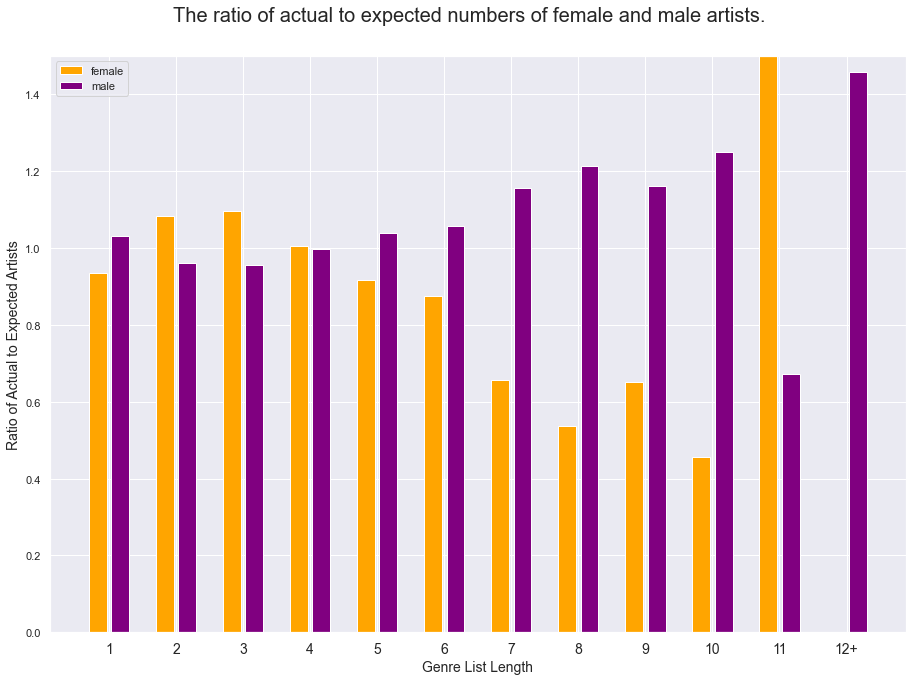

In [43]:
fig = plot_bias_l2_bins(lcbg_12_bin)